In [1]:
from FluxPy.CFDSolve import *
import h5py
import os


(204, 204)
(204, 204)
(204, 204)

                ________           ____       
               / ____/ /_  ___  __/ __ |__  __
              / /_  / / / / / |/_/ /_/ / / / /
             / __/ / / /_/ />  </ ____/ /_/ / 
            /_/   /_/\__,_/_/|_/_/    \__, /  
                                     /____/   

time: 0 s


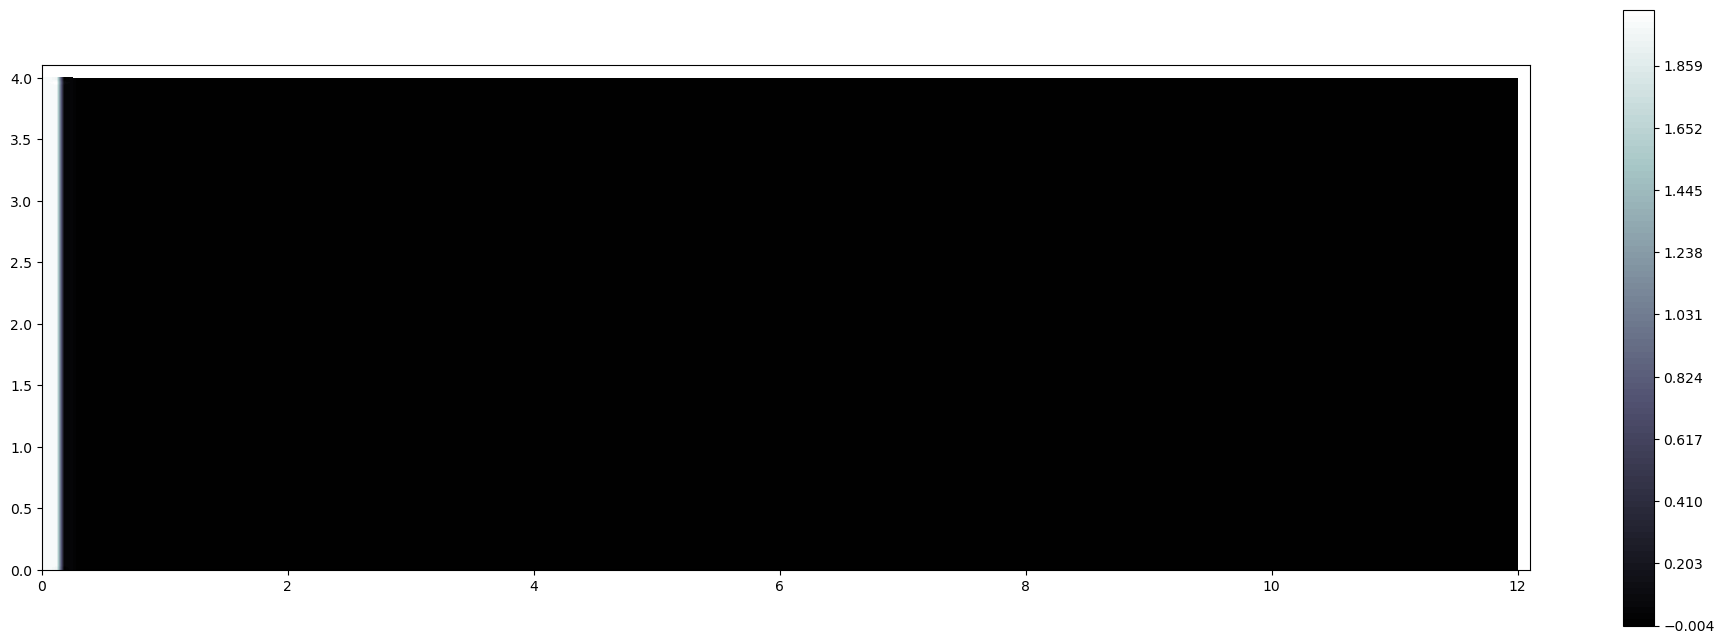

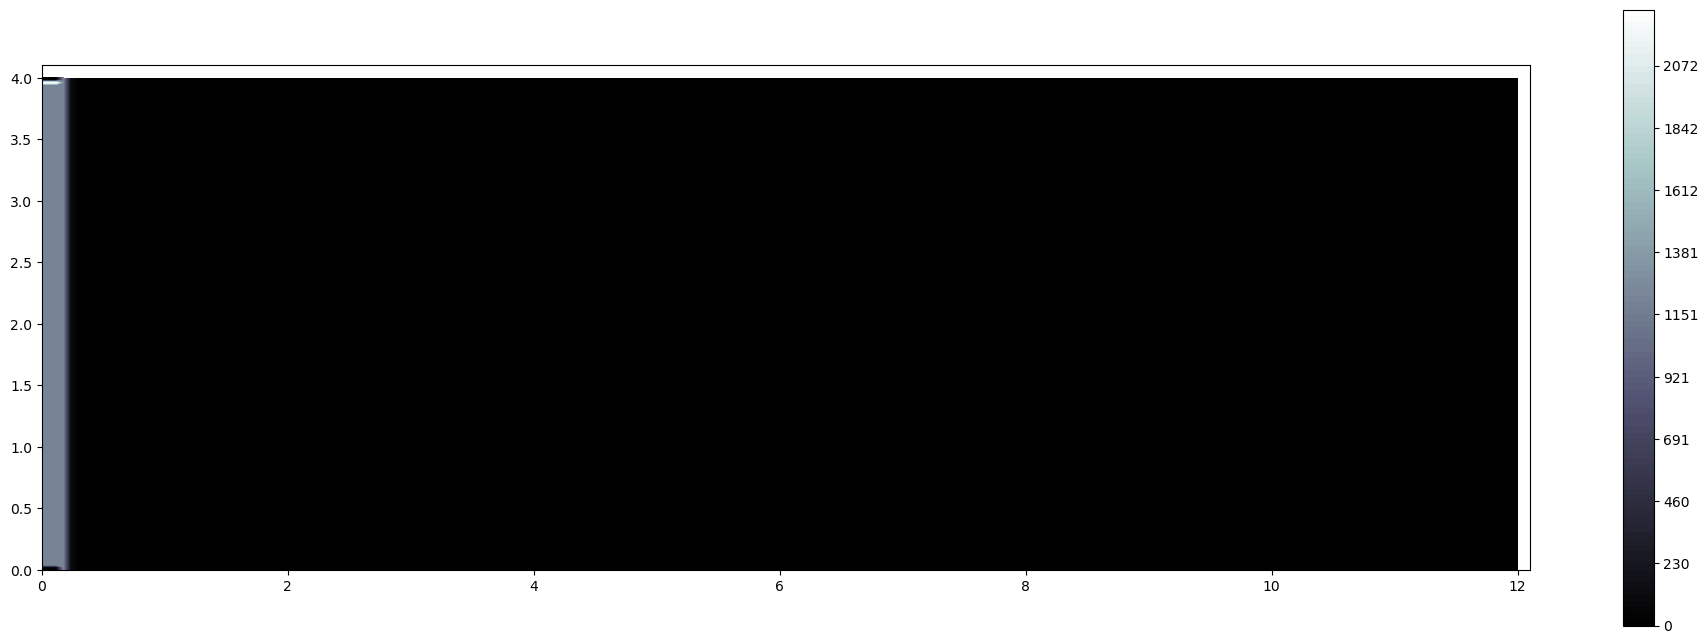

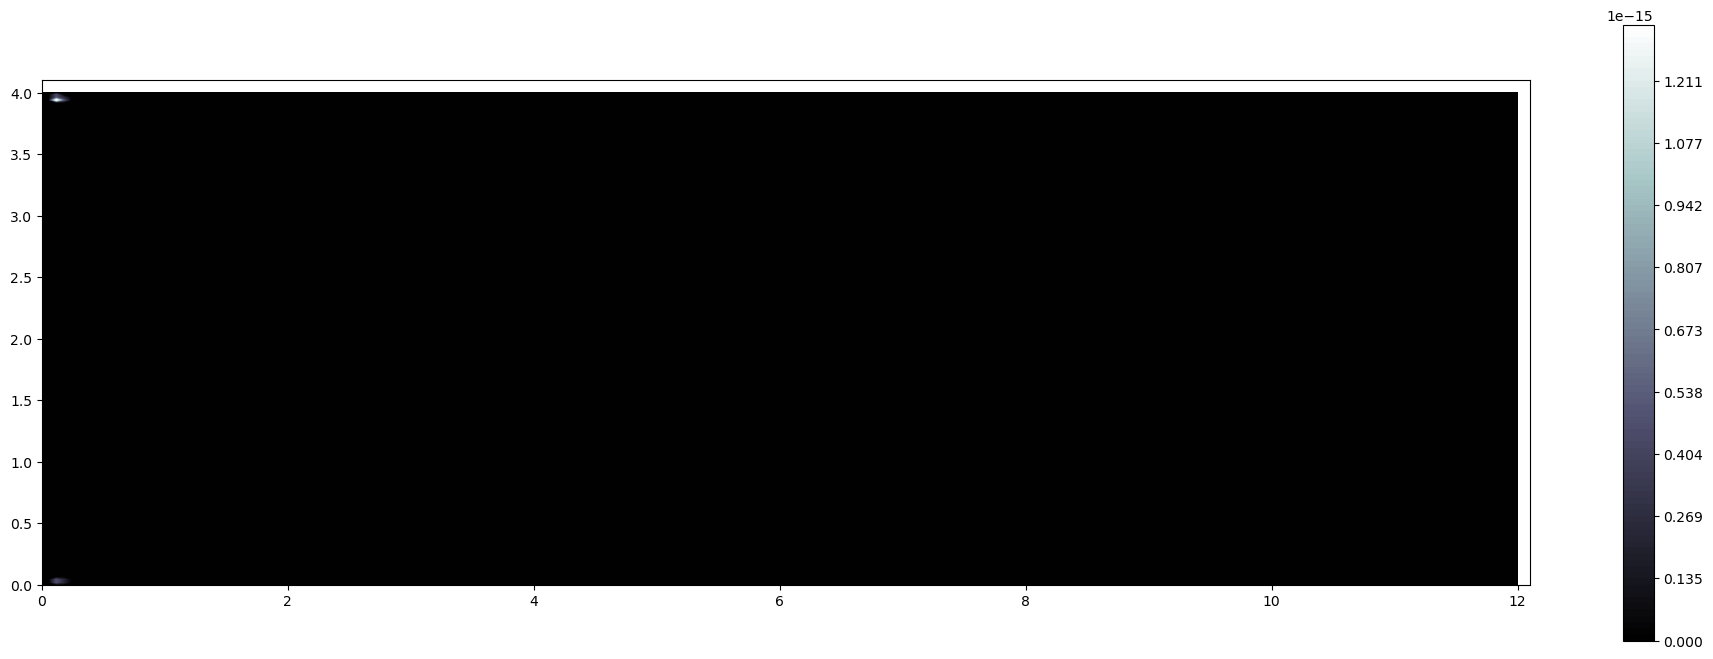

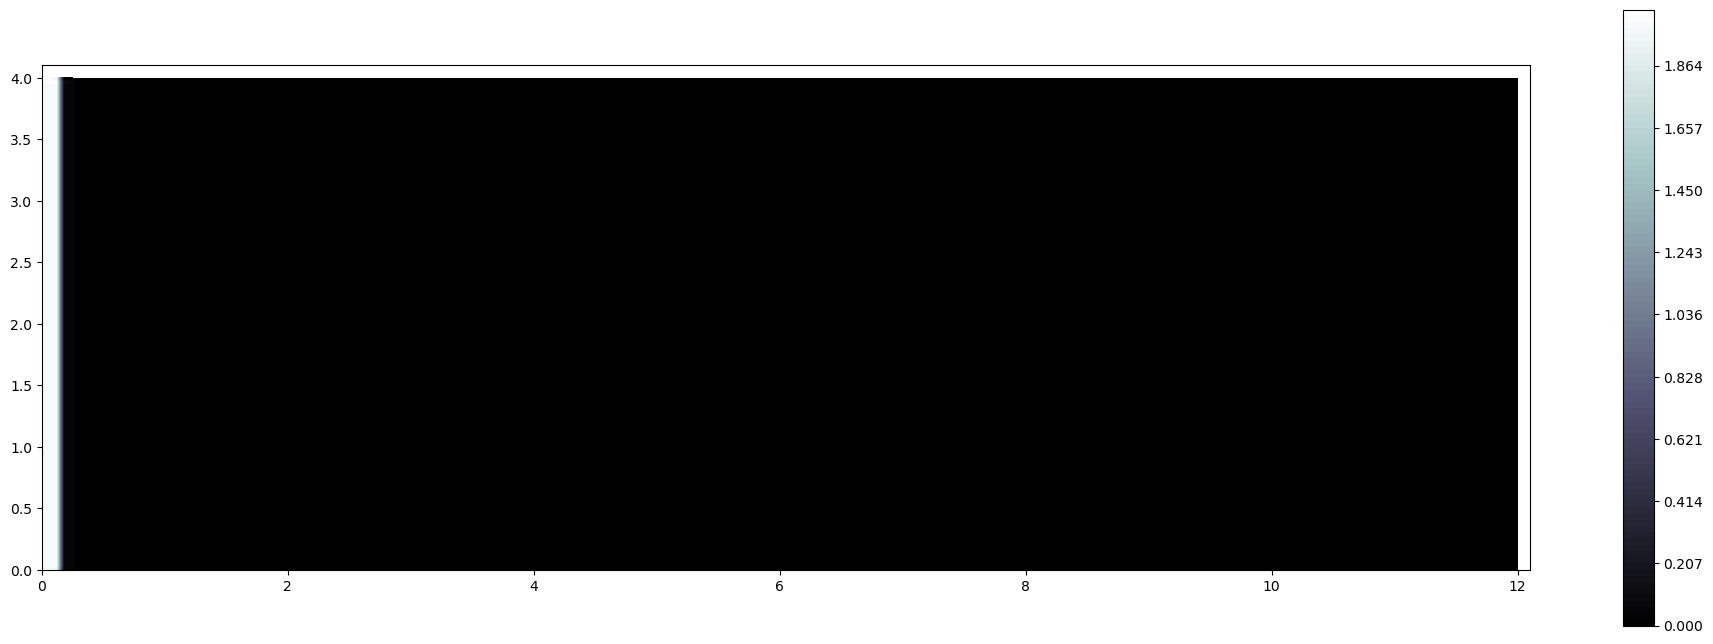

[[2.000e+000 4.612e-002 5.025e-002 ... 4.381e-205 4.016e-206 3.650e-207]
 [2.000e+000 4.612e-002 5.025e-002 ... 4.381e-205 4.016e-206 3.650e-207]
 [2.000e+000 4.612e-002 5.025e-002 ... 4.381e-205 4.016e-206 3.650e-207]
 ...
 [2.000e+000 4.612e-002 5.025e-002 ... 4.381e-205 4.016e-206 3.650e-207]
 [2.000e+000 4.612e-002 5.025e-002 ... 4.381e-205 4.016e-206 3.650e-207]
 [2.045e+000 9.111e-002 5.025e-002 ... 4.381e-205 4.016e-206 3.650e-207]]
[[1.200e+003 1.200e+003 1.094e+002 ... 9.637e-202 8.761e-203 0.000e+000]
 [1.200e+003 1.200e+003 1.094e+002 ... 9.637e-202 8.761e-203 0.000e+000]
 [1.200e+003 1.200e+003 1.094e+002 ... 9.637e-202 8.761e-203 0.000e+000]
 ...
 [1.200e+003 1.200e+003 1.094e+002 ... 9.637e-202 8.761e-203 0.000e+000]
 [1.200e+003 1.200e+003 1.094e+002 ... 9.637e-202 8.761e-203 0.000e+000]
 [2.279e+003 1.200e+003 1.094e+002 ... 9.637e-202 8.761e-203 0.000e+000]]
time: 0.0049999999999974995 s
time: 0.009876920485897923 s


KeyboardInterrupt: 

In [2]:
run_num = 5
path = "/home/jacob.schaefer/SogGitlab/FluxPy/FluxPy"

def save_to_file(file_index:int, data:dict):
    with h5py.File(f'{path}/figs/run{run_num}/data/data_{file_index}.h5', 'w') as f:
        for dataset_name, dataset_values in data.items():
            f.create_dataset(dataset_name, data=dataset_values, dtype=np.float64, chunks=True)


def main():
    # 2D Cylinder Geometry
    center = np.array([1.5,2])
    radius = 0.25

    # A common setup would be to have the domain length 10-20 times the diameter of the cylinder in the 
    # flow direction and 5-10 times the diameter in the cross-flow 
    # Length and height of our domain (in meters) -> we will not be working 
    # with a characteristice length scale here 
    Lx, Ly = 12.0, 4.0
    # Number of cells in each direction
    numX, numY = 100, 100
    # grid spacing (Δx, Δy not actually dx or dy)
    dx = Lx/numX
    dy = Ly/numY
    X, Y = np.meshgrid(np.linspace(0, Lx, numX+4), np.linspace(0, Ly, numY+4))

    # Density of water in kg/m^3
    rho = 1000 # * u.kg/(u.m**3)
    # dynamic viscosity coefficient
    mu = 1.0e-3 # * u.Pa # for water -> Pa s
    inlet_velocity = 2
    CFL = 0.5

    # Time stuff
    max_dt = 0.00625
    dt = 0.00625
    nt = 10000
    max_iters = int(nt/dt)

    # THESE ARE THE BCS FOR VORTEX SHEDDING PAST A CYLINDER
    # Mask for only points inside the cylinder
    inside = inside_cylinder(X, Y, radius, center)
    # These are the default boundary conditions for vortex shedding past a cylinder
    # Most simulations are extremely sensitive to changes in boundary conditions because
    # they are dealing with nonlinear systems
    BCS = {
        'u':{
            'left':   {'condition': Dirichlet, 'value': inlet_velocity},
            'right':  {'condition': Neumann, 'value': 0, 'type': 'zerograd'}, 
            'top':    {'condition': Neumann, 'value': 0}, 
            'bottom': {'condition': Neumann, 'value': 0},
            'custom': {'boundary' : inside, 'value': 0}
            }, 
        'v':{
            'left':   {'condition': Dirichlet, 'value': 0}, 
            'right':  {'condition': Neumann, 'value': 0, 'type': 'zerograd'},
            'top':    {'condition': Neumann, 'value': 0}, 
            'bottom': {'condition': Neumann, 'value': 0},
            'custom': {'boundary' : inside, 'value': 0}
            }, 
        'p':{
            'left':   {'condition': Neumann,   'value': 0,   'type': 'zerograd'}, 
            'right':  {'condition': Dirichlet, 'value': 0}, 
            'top':    {'condition': Neumann,   'value': 0,   'type': 'zerograd'}, 
            'bottom': {'condition': Neumann,   'value': 0,   'type': 'zerograd'}
            }
        }
    
    # Priority order in which the boundary conditions will be considered
    # The simulation is also extremely sensitive to changes in this
    priority_map = {
        'Neumann': 2,
        'Outflow':2,
        'NoSlip':2,
        'Dirichlet': 1,
        'Inflow':3
        }

    constants =  {'rho':rho, 'mu':mu}

    # Initialize the large eddy simualtion class
    solver = LES((Lx, Ly), (numX, numY), BCS, priority_map, nghosts=2, constants=constants)
    iter = 0
    t = 0
    path = "/home/jacob.schaefer/SogGitlab/FluxPy/FluxPy"
    # This is for collecting the data in case you want to process it later
    
    data_dict = {'u':[], 'v':[], 'p':[]}
    while iter < max_iters:
        dt = min(max_dt, CFL * min(solver.mesh.dx, solver.mesh.dy) / (np.max(np.sqrt(solver.mesh['u'][:,:]**2 + solver.mesh['v'][:,:]**2))+ 1e-12))
        solver.mesh.apply_all_boundaries()

        # Filter the mesh
        solver.mesh['u'][:,:] = Filter.gaussian(solver.mesh['u'][:,:], sigma=solver.mesh.dx)
        solver.mesh['v'][:,:] = Filter.gaussian(solver.mesh['v'][:,:], sigma=solver.mesh.dx)

        # Calculate the Fluxes
        conv_flux_x_u, conv_flux_y_u = solver._convective_flux('u')
        conv_flux_x_v, conv_flux_y_v = solver._convective_flux('v')
        Fvu, Fvv = solver._viscous_flux()
        
        # Get intermediate velocities
        solver.mesh['u'][:,:], solver.mesh['v'][:,:] = solver.calculate_intermediate_velocities(solver.mesh['u'][:,:], solver.mesh['v'][:,:], dt, (conv_flux_x_u, conv_flux_y_u, conv_flux_x_v, conv_flux_y_v), (Fvu, Fvv))
        solver.mesh.apply_all_boundaries()        

        # Solve for the pressure correction term 
        # There are currently 3 different solvers that I have implemented, but I have found 
        # that gauss_seidel is the most accurate
        solver.mesh['p'][2:-2,2:-2] = solver.solvePressureCorrectionEquation(dt, solver=EquilibriumSolver.gauss_seidel)
        solver.mesh.apply_all_boundaries()

        # Update the velocity fields
        solver.mesh['u'][:,:], solver.mesh['v'][:,:] = solver.updateVelocityField(solver.mesh['u'][:,:], solver.mesh['v'][:,:], solver.mesh['p'][:,:], dt)

        # Log the data
        if iter % 2 == 0:
            data_dict['u'].append(np.copy(solver.mesh['u'][:,:]))
            data_dict['v'].append(np.copy(solver.mesh['v'][:,:]))
            data_dict['p'].append(np.copy(solver.mesh['p'][:,:]))

        print('time:', t, 's')

        if iter % 100 == 0:
            save_to_file(iter//100, data_dict)
            del data_dict
            data_dict = {'u':[], 'v':[], 'p':[]}

        if iter % 25 == 0:
            size_x, size_y =  solver.mesh.size[1], solver.mesh.size[0]
            X, Y = solver.mesh.X, solver.mesh.Y
            u, v, p = solver.mesh['u'][:,:], solver.mesh['v'][:,:], solver.mesh['p'][:,:]

            # u velocity
            path_u = f"{path}/figs/run{run_num}/u_velocity_figs/fig{iter}.png"
            plot_field(X, Y, u, size_x, size_y, save=True, path=path_u, show=True)
            

            # Pressure
            path_p = f"{path}/figs/run{run_num}/pressure_figs/fig{iter}.png"
            plot_field(X, Y, p,  size_x, size_y, save=True, path=path_p, show=True)

            # Vorticity
            path_omega = f"{path}/figs/run{run_num}/vortex_figs/fig{iter}.png"
            omega = np.abs(curl(u, v, dx, dy))
            plot_field(X, Y, omega,  size_x, size_y, save=True, path=path_omega, show=True)
            
            # velocity magnitude    
            path_mag = f"{path}/figs/run{run_num}/mag_velocity_figs/fig{iter}.png"
            mag = np.sqrt(u**2 + v**2)
            plot_field(X, Y, mag, size_x, size_y, save=True, path=path_mag, show=True)

            print(solver.mesh['u'][2:-2, 2:-2])
            print(solver.mesh['p'][2:-2, 2:-2])

        t+=dt
        iter +=1

if __name__ == '__main__':
    main()

